# Imports and Paths

In [39]:
import json
import os
import re
import string
import numpy as np
import pandas as pd
import glob
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split


# replace it with path on your desktop
root_path = '/home/siri/Downloads/CORD-19-research-challenge'
file_path = '/home/siri/Downloads/CORD-19-research-challenge/2020-03-13/all_sources_metadata_2020-03-13.csv'

# Get Meta Data

In [3]:
meta_df = pd.read_csv(file_path)

In [4]:
meta_df.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


In [5]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29500 entries, 0 to 29499
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sha                          17420 non-null  object 
 1   source_x                     29500 non-null  object 
 2   title                        29130 non-null  object 
 3   doi                          26357 non-null  object 
 4   pmcid                        27337 non-null  object 
 5   pubmed_id                    16730 non-null  float64
 6   license                      17692 non-null  object 
 7   abstract                     26553 non-null  object 
 8   publish_time                 18248 non-null  object 
 9   authors                      28554 non-null  object 
 10  journal                      17791 non-null  object 
 11  Microsoft Academic Paper ID  1134 non-null   float64
 12  WHO #Covidence               1236 non-null   object 
 13  has_full_text   

# Get filenames of whitepapers

In [6]:
# these are in json format
all_json = glob.glob(f'{root_path}/**/*.json',recursive=True)
len(all_json)

13202

# Read main contents of each file

In [7]:
# Read paper id, abstract and body
class Json_reader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id} : {self.abstract[:200]}....{self.body_text[:200]}..'

# Peek into the first row

In [8]:
first_row = Json_reader(all_json[0])
print(first_row)

346f7bb753e53598554deae2f428d0ce66a8320a : A prospective study of a dromedary camel herd during the 2013-14 calving season showed Middle East respiratory syndrome coronavirus infection of calves and adults. Virus was isolated from the nose and....We studied dromedaries at 2 farms in Al-Hasa, 4-5 km apart. Farm A had 70 animals; 4 were 1 month of age, 8 were ≈1 year of age, and the rest were adults (>2 years of age). The herd did not go to past..


# Converting to a Dataframe

In [9]:
literature_dict = {'paper_id' :[],'abstract':[],'body_text':[],'title':[],'journal':[]}

for entry in all_json:
    content = Json_reader(entry)
    
    meta_info = meta_df.loc[meta_df['sha'] == content.paper_id]
    if len(meta_info) == 0:
        continue
    literature_dict['paper_id'].append(content.paper_id)
    literature_dict['abstract'].append(content.abstract)
    literature_dict['body_text'].append(content.body_text)
    
    #authors = meta_info['authors'].values[0]
    #if pd.isna(authors):
    #    literature_dict['authors'].append(authors)
    #else:
    #    literature_dict['authors'].append('. '.join(authors.split(';')))
    literature_dict['title'].append(meta_info['title'].values[0])
    literature_dict['journal'].append(meta_info['journal'].values[0])
df_covid_lit = pd.DataFrame(literature_dict)
df_covid_lit.head()


,paper_id,abstract,body_text,title,journal
0,346f7bb753e53598554deae2f428d0ce66a8320a,A prospective study of a dromedary camel herd ...,"We studied dromedaries at 2 farms in Al-Hasa, ...","MERS Coronavirus in Dromedary Camel Herd, Saud...",Emerg Infect Dis
1,0e547f3723a50ef4f55c873f2a65dfbee42cd655,,(10 −1 -10 −9 ) plus 1 negative control (phosp...,Protocol for Metagenomic Virus Detection in Cl...,Emerg Infect Dis
2,e1dd5b5b1884508b0e49421388eb658f9f9949e1,The aim of this review is to examine the cause...,Pharyngitis is inflammation of the oropharynx....,Environmental and non-infectious factors in th...,Inflamm Res
3,f76e23d2dce15bbfa44c92cb917bf718ade1472e,,O utbreaks of severe acute respiratory syndrom...,Pets in Voluntary Household Quarantine,Emerg Infect Dis
4,768fb5bff1898a4076849b7d5318402a62cb0bfe,,Dromedary camels from Africa and Arabia are an...,Serologic Evidence for MERS-CoV Infection in D...,Emerg Infect Dis


# Adding the word counts of abstract and body

In [10]:
df_covid_lit['abstract_word_count'] = df_covid_lit['abstract'].apply(lambda x:len(x.strip().split()))
df_covid_lit['body_word_count'] = df_covid_lit['body_text'].apply(lambda x:len(x.strip().split()))
df_covid_lit.head()

,paper_id,abstract,body_text,title,journal,abstract_word_count,body_word_count
0,346f7bb753e53598554deae2f428d0ce66a8320a,A prospective study of a dromedary camel herd ...,"We studied dromedaries at 2 farms in Al-Hasa, ...","MERS Coronavirus in Dromedary Camel Herd, Saud...",Emerg Infect Dis,48,1181
1,0e547f3723a50ef4f55c873f2a65dfbee42cd655,,(10 −1 -10 −9 ) plus 1 negative control (phosp...,Protocol for Metagenomic Virus Detection in Cl...,Emerg Infect Dis,0,768
2,e1dd5b5b1884508b0e49421388eb658f9f9949e1,The aim of this review is to examine the cause...,Pharyngitis is inflammation of the oropharynx....,Environmental and non-infectious factors in th...,Inflamm Res,186,5390
3,f76e23d2dce15bbfa44c92cb917bf718ade1472e,,O utbreaks of severe acute respiratory syndrom...,Pets in Voluntary Household Quarantine,Emerg Infect Dis,0,968
4,768fb5bff1898a4076849b7d5318402a62cb0bfe,,Dromedary camels from Africa and Arabia are an...,Serologic Evidence for MERS-CoV Infection in D...,Emerg Infect Dis,0,832


# Check to see the presence of duplicates

In [58]:
df_covid_lit['abstract'].describe(include='all')

count     13202
unique    11113
top            
freq       2073
Name: abstract, dtype: object

# Drop duplicates

In [59]:
df_covid_lit.drop_duplicates(['abstract','body_text'], inplace=True)

# Check if body of the text document is unique

In [11]:
df_covid_lit['body_text'].describe(include='all')

count                                                 13202
unique                                                13192
top       A 54-year-old Korean man living in Wuhan, Chin...
freq                                                      2
Name: body_text, dtype: object

In [12]:
df_covid_lit.describe()

,abstract_word_count,body_word_count
count,13202.000000,13202.000000
mean,210.911604,4259.200273
std,198.086664,4707.945123
min,0.000000,1.000000
25%,112.000000,2477.250000
50%,200.000000,3717.000000
75%,271.000000,5363.750000
max,4170.000000,241076.000000


# Drop missing values

In [13]:
df_covid_lit.dropna(inplace=True)
df_covid_lit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12399 entries, 0 to 12398
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             12399 non-null  object
 1   abstract             12399 non-null  object
 2   body_text            12399 non-null  object
 3   title                12399 non-null  object
 4   journal              12399 non-null  object
 5   abstract_word_count  12399 non-null  int64 
 6   body_word_count      12399 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 774.9+ KB


# Do text processing

# Remove all characters except letters and numbers

In [14]:
df_covid_lit['body_text'] = df_covid_lit['body_text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]','',x))
df_covid_lit['abstract'] = df_covid_lit['abstract'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]','',x))

# Convert to lower case

In [15]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_covid_lit['body_text'] = df_covid_lit['body_text'].apply(lambda x: lower_case(x))
df_covid_lit['abstract'] = df_covid_lit['abstract'].apply(lambda x: lower_case(x))

In [16]:
df_covid_lit.head()

,paper_id,abstract,body_text,title,journal,abstract_word_count,body_word_count
0,346f7bb753e53598554deae2f428d0ce66a8320a,a prospective study of a dromedary camel herd ...,we studied dromedaries at 2 farms in alhasa 45...,"MERS Coronavirus in Dromedary Camel Herd, Saud...",Emerg Infect Dis,48,1181
1,0e547f3723a50ef4f55c873f2a65dfbee42cd655,,10 1 10 9 plus 1 negative control phosphatebu...,Protocol for Metagenomic Virus Detection in Cl...,Emerg Infect Dis,0,768
2,e1dd5b5b1884508b0e49421388eb658f9f9949e1,the aim of this review is to examine the cause...,pharyngitis is inflammation of the oropharynx ...,Environmental and non-infectious factors in th...,Inflamm Res,186,5390
3,f76e23d2dce15bbfa44c92cb917bf718ade1472e,,o utbreaks of severe acute respiratory syndrom...,Pets in Voluntary Household Quarantine,Emerg Infect Dis,0,968
4,768fb5bff1898a4076849b7d5318402a62cb0bfe,,dromedary camels from africa and arabia are an...,Serologic Evidence for MERS-CoV Infection in D...,Emerg Infect Dis,0,832


# Getting Bigrams- Optional

In [34]:
text = df_covid_lit['body_text']
text = pd.DataFrame(text.values, columns = ['body_text'])
words = []
for i in range(0,len(text)):
    words.append(str(text.iloc[i]['body_text']).split(" "))
bigrams = []
for word in words:
    bi_gram = []
    for i in range(len(word)-2+1):
        n_gram.append("".join(word[i:i+2]))
    bigrams.append(n_gram)

# Using TF-IDF Vectorizer

In [33]:
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',max_features = 2**12)
tf_idf = tf_idf_vectorizor.fit_transform(df_covid_lit['body_text'])
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

,000,00001,0001,001,002,005,01,02,025,03,...,yielded,yields,young,younger,zero,zika,zikv,zinc,zone,zoonotic
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.034442,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.004019,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.028818
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.023215,0.0,0.0,0.0,0.0,0.0,0.0,0.051976


# Using PCA and KMeans for Clustering

In [41]:
sklearn_pca = PCA(n_components = 10)
X = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=10, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(X)
prediction = kmeans.predict(X)

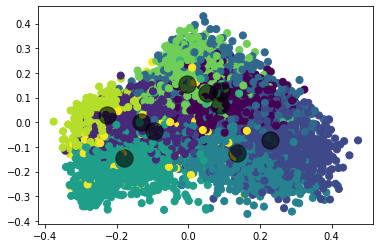

In [42]:
plt.scatter(X[:, 0], X[:, 1], c=prediction, s=50, cmap='viridis')
centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);